## PySpark imports for ML and Dataframe

In [1]:
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

## Plotting routines

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

## Isarn: Feature Importance Using Generative T-Digests

In [3]:
from isarnproject.pipelines.fi import *

### Load Tox21 data from CSV to Dataframes

In [4]:
def loadCSV(fname):
    return spark.read \
        .format("com.databricks.spark.csv") \
        .option("header", "true") \
        .option("mode", "DROPMALFORMED") \
        .load(fname)

In [5]:
trainCSV = loadCSV("./tox21/tox21_dense_train.csv")
testCSV = loadCSV("./tox21/tox21_dense_test.csv")
trainLabelsCSV = loadCSV("./tox21/tox21_labels_train.csv")
testLabelsCSV = loadCSV("./tox21/tox21_labels_test.csv")

### There are 12 toxicity assays

In [6]:
depVars = trainLabelsCSV.columns[1:]
depVars

['NR.AhR',
 'NR.AR',
 'NR.AR.LBD',
 'NR.Aromatase',
 'NR.ER',
 'NR.ER.LBD',
 'NR.PPAR.gamma',
 'SR.ARE',
 'SR.ATAD5',
 'SR.HSE',
 'SR.MMP',
 'SR.p53']

### Labeled sub-sets are different for each assay

In [7]:
trainLabelsCSV.drop("_c0").show()

+------+-----+---------+------------+-----+---------+-------------+------+--------+------+------+------+
|NR.AhR|NR.AR|NR.AR.LBD|NR.Aromatase|NR.ER|NR.ER.LBD|NR.PPAR.gamma|SR.ARE|SR.ATAD5|SR.HSE|SR.MMP|SR.p53|
+------+-----+---------+------------+-----+---------+-------------+------+--------+------+------+------+
|    NA|   NA|       NA|          NA|   NA|       NA|           NA|    NA|      NA|     0|    NA|    NA|
|    NA|   NA|       NA|          NA|   NA|       NA|           NA|    NA|      NA|     0|    NA|    NA|
|    NA|   NA|       NA|          NA|   NA|       NA|           NA|    NA|      NA|     0|    NA|    NA|
|    NA|   NA|       NA|          NA|   NA|       NA|           NA|    NA|      NA|     1|    NA|    NA|
|    NA|    0|       NA|          NA|   NA|       NA|           NA|    NA|      NA|    NA|    NA|    NA|
|    NA|   NA|       NA|          NA|   NA|       NA|           NA|    NA|      NA|     1|    NA|    NA|
|    NA|   NA|       NA|          NA|   NA|       NA|  

### About 2/3 of samples are labeled for each assay

In [8]:
[trainLabelsCSV.select("`"+c+"`").filter(col("`"+c+"`") != "NA").count() for c in depVars]

[8441, 9654, 8852, 7440, 7962, 9040, 8451, 7401, 9363, 8417, 7558, 8903]

### Convert individual feature columns to ML Vectors

In [9]:
vectorAssembler = VectorAssembler(inputCols=trainCSV.columns[1:], outputCol="features")
castToDouble = [col(c).cast("Double").alias(c) for c in vectorAssembler.getInputCols()]

trainFV = vectorAssembler.transform(trainCSV.select("_c0", *castToDouble)).select("_c0", "features").repartition(8).cache()
testFV = vectorAssembler.transform(testCSV.select("_c0", *castToDouble)).select("_c0", "features").repartition(8).cache()

In [10]:
def labDef(lc, fData, lData):
    lcol = "`" + lc + "`"
    ldef = lData.filter(col(lcol) != "NA").select("_c0", *[(col(lcol).cast("Double").alias("label"))])
    return ldef.join(fData, "_c0")

### For each assay: identify the labeled sub-set and sync with the feature vectors

In [11]:
trainSets = dict([(y, labDef(y, trainFV, trainLabelsCSV)) for y in depVars])
testSets = dict([(y, labDef(y, testFV, testLabelsCSV)) for y in depVars])

### For each assay: Fit a toxicity model using Logistic Regression

In [12]:
lr = LogisticRegression(maxIter=10)
lrModels = dict([(y, lr.fit(trainSets[y])) for y in depVars])

## Fit a Feature Importance model to the training data
### A T-Digest sketch of the value distribution for each feature

In [13]:
fi = TDigestFI() \
    .setDelta(0.75) \
    .setMaxDiscrete(35)

fiModel = fi.fit(trainFV) \
    .setFeatureNames(trainCSV.columns[1:])

## For each Toxicity Model: Apply the Feature Importance model

In [14]:
imps = dict([(y, \
              fiModel.setTargetModel(lrModels[y]) \
                  .transform(trainSets[y]) \
                  .sort(-col("importance"))) \
             for y in depVars])

## Features and their Importance, sorted descending

In [15]:
imps['NR.AhR'].show()

+----------+--------------------+
|      name|          importance|
+----------+--------------------+
| slogPVSA7|0.011017651936974291|
|    MRVSA9|0.005686530031986731|
| slogPVSA9| 0.00521265252932117|
|    nnitro| 0.00509418315365478|
|       P3u|   0.004857244402322|
|  PEOEVSA7| 0.00473877502665561|
|       P3e|0.004620305650989219|
|EstateVSA9|0.004264897523990...|
| PEOEVSA12|0.004146428148323659|
|       P3v|0.004146428148323659|
|    MATSm1|0.003909489396990878|
|      naro|0.003909489396990878|
|slogPVSA10|0.003672550645658...|
|       P3p|0.003554081269991707|
|     PNSA3|0.003554081269991707|
|     FNSA3|0.003435611894325317|
|     mChi1|0.003435611894325317|
|    GATSm1|0.003435611894325317|
|EstateVSA8|0.003317142518658...|
|       ndb|0.003198673142992...|
+----------+--------------------+
only showing top 20 rows



### Extract importance values to a pandas DataFrame

In [16]:
rawImps = pd.DataFrame(dict([(y, imps[y].select("importance").rdd.map(lambda r: r[0]).collect()) for y in depVars]))

## Histogram the Feature Importances for a Toxicity Model
## Distribution is Zipfian

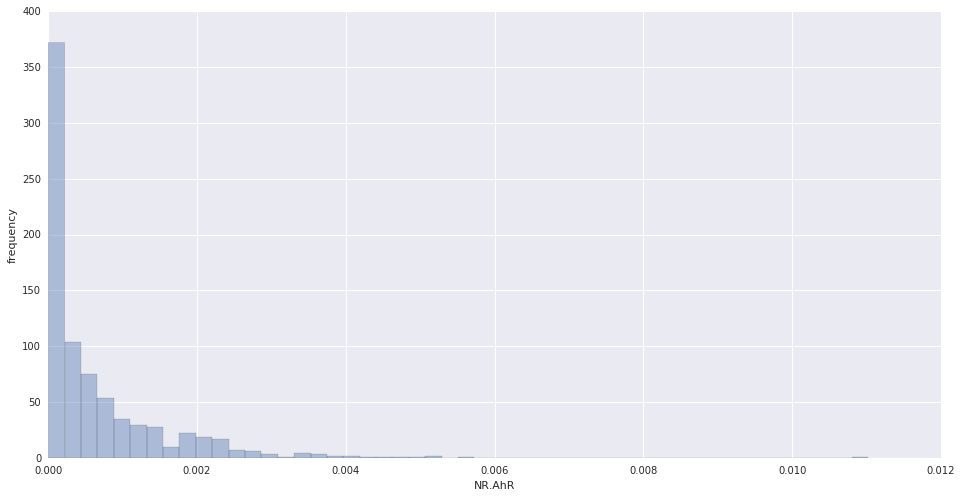

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
ax.axes.xaxis.set_label_text("importance")
ax.axes.yaxis.set_label_text("frequency")
sns.distplot(rawImps['NR.AhR'], kde=False, ax=ax)

## Visualize the Feature Importances for all Toxicity Models

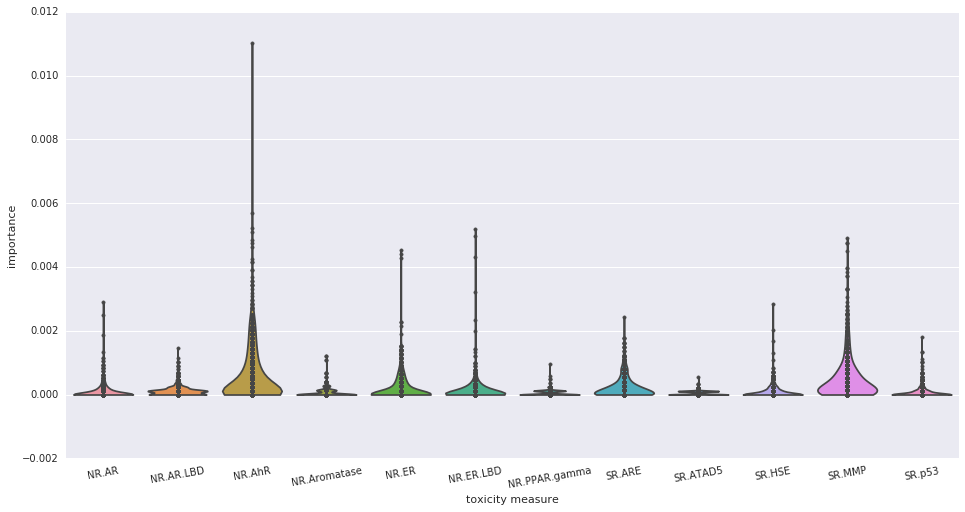

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
ax.axes.xaxis.set_label_text("toxicity measure")
ax.axes.yaxis.set_label_text("importance")
for tick in ax.get_xticklabels():
    tick.set_rotation(10)
sns.violinplot(data=rawImps, inner="points", scale="width", cut=0, ax=ax)